In [1]:
# 베이스라인 코드 기반
# 시범 submission

In [2]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [4]:
pd.set_option('display.max_columns', None)  # 모든 열 보기
pd.set_option('display.max_rows', None)     # 모든 행 보기
pd.set_option('display.max_colwidth', None) # 열 너비 제한 해제

In [5]:
## 데이터 로드

In [6]:
train_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/train.csv'
test_path  = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [7]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [8]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))  

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [10]:
## 데이터 전처리

In [11]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# is_data 컬럼에 저장
dt['is_data'] = 0
dt_test['is_data'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [12]:
# concat으로 합쳐진 concat(변수명) 데이터 보기
dt.shape, dt_test.shape, concat.shape

((1118822, 53), (9272, 52), (1128094, 53))

In [13]:
concat['is_data'].value_counts() 

# 0은 학습 데이터
# 1은 테스트 데이터

0    1118822
1       9272
Name: is_data, dtype: int64

In [14]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [15]:
## 결측치 탐색 및 보간

In [16]:
# 값 확인

display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
20230530        367
20230728        357
20230915        326
20230830        310
20230531        305
20230825        244
20230526        231
20230828        209
20230920        208
20230331        200
20230714        200
20230908        198
20230818        197
20230519        191
20230727        187
20230810        180
20230720        172
20230901        171
20230710        169
20230525        168
20230814        164
20230602        153
20230811        153
20230615        153
20230502        148
20230609        148
20230725        146
20230904        144
20230620        139
20230707        139
20230427        138
20230816        138
20230821        132
20230918        131
20230914        131
20230512        125
20230721        125
20230605        125
20230726        124
20230703        124
20230824        123
20230817        123
20230616        122
20230629        121
20230911        119


In [17]:
# 그냥 궁금해서 ㅎㅎ

display(concat['아파트명'].value_counts())

현대                      16779
신동아                     12929
한신                       9128
두산                       8593
주공2                      7955
우성                       7824
벽산                       7329
삼성래미안                    7185
대림                       6349
극동                       5697
삼성                       5197
대우                       4691
삼익                       4487
성원                       4487
파크리오                     4372
경남아너스빌                   4091
미성                       4071
에스케이북한산시티                4049
대림e-편한세상                 3763
주공5                      3712
중앙하이츠                    3609
한진                       3600
쌍용                       3544
중계그린1단지                  3327
동아                       3322
청구                       3241
관악드림                     3197
리센츠                      3088
잠실엘스                     3068
현대1                      3043
롯데캐슬                     2991
코오롱                      2923
선사현대                     2874
관악산벽산타운5  

In [18]:
# 거래 유형이 왜 의미 없는 element지?

display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [19]:
display(concat['중개사소재지'].value_counts())

-                           1090013
서울 노원구                         2627
서울 송파구                         2540
서울 강남구                         2508
서울 강동구                         2038
서울 서초구                         1733
서울 강서구                         1728
서울 성북구                         1723
서울 영등포구                        1704
서울 구로구                         1611
서울 동대문구                        1569
서울 양천구                         1523
서울 마포구                         1521
서울 은평구                         1427
서울 성동구                         1427
서울 도봉구                         1235
서울 동작구                         1228
서울 서대문구                        1223
서울 관악구                         1000
서울 중랑구                          933
서울 광진구                          665
서울 금천구                          579
서울 용산구                          572
서울 강북구                          566
서울 중구                           475
서울 종로구                          330
서울 강남구, 서울 서초구                  120
서울 강남구, 서울 송파구              

In [20]:
# 열 전체를 넣고 스캔하기

for col in concat.columns:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    print(f"📌 {col:30} | 고유값: {nunique:6} | 결측률: {missing_ratio:.2%}")


📌 시군구                            | 고유값:    339 | 결측률: 0.00%
📌 번지                             | 고유값:   6579 | 결측률: 0.02%
📌 본번                             | 고유값:   1524 | 결측률: 0.01%
📌 부번                             | 고유값:    330 | 결측률: 0.01%
📌 아파트명                           | 고유값:   6550 | 결측률: 0.19%
📌 전용면적                           | 고유값:  14670 | 결측률: 0.00%
📌 계약년월                           | 고유값:    201 | 결측률: 0.00%
📌 계약일                            | 고유값:     31 | 결측률: 0.00%
📌 층                              | 고유값:     73 | 결측률: 0.00%
📌 건축년도                           | 고유값:     60 | 결측률: 0.00%
📌 도로명                            | 고유값:   9245 | 결측률: 0.00%
📌 해제사유발생일                        | 고유값:   1034 | 결측률: 99.45%
📌 등기신청일자                         | 고유값:    182 | 결측률: 0.00%
📌 거래유형                           | 고유값:      3 | 결측률: 0.00%
📌 중개사소재지                         | 고유값:    739 | 결측률: 0.00%
📌 k-단지분류(아파트,주상복합등등)             | 고유값:      6 | 결측률: 77.77%
📌 k-전화번호                         | 고유값

In [21]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [22]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

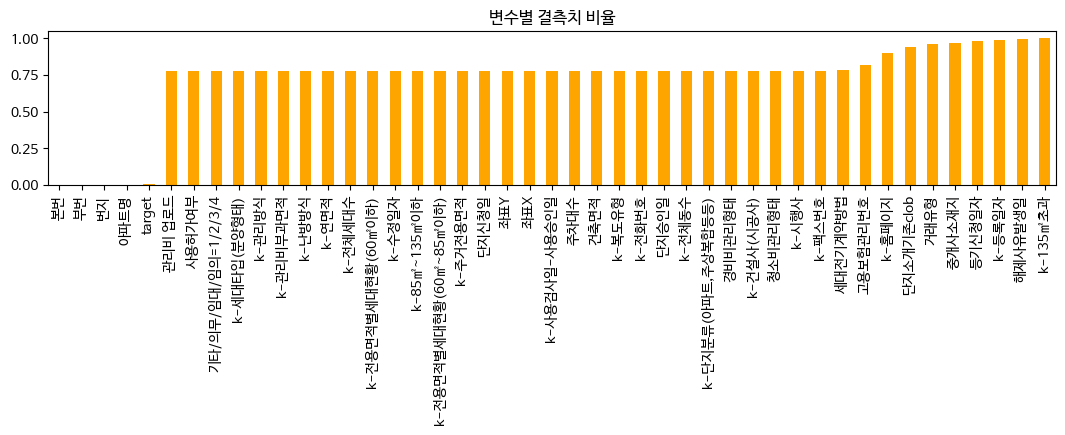

In [23]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [24]:
print(concat.shape[0] * 0.9)

1015284.6


In [25]:
print(concat.shape[0] * 0.8)

902475.2000000001


In [26]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_data']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [27]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [28]:
concat.shape, concat_select.shape

((1128094, 53), (1128094, 45))

In [29]:
concat_select.isnull().sum() 

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [30]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [31]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [32]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# 숫자형 분리 pd.api.types.is_numeric_dtype
con_columns = []
cat_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns.append(column)
    else:
        cat_columns.append(column)

print("연속형 변수:", con_columns)
print("범주형 변수:", cat_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_data']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [33]:
# 범주형 변수에 대한 보간
concat_select[cat_columns] = concat_select[cat_columns].fillna('Unknown')

In [34]:
# 연속형 변수에 대한 보간 (선형 보간)
# 보간 interpolate
concat_select[con_columns] = concat_select[con_columns].interpolate(method='linear', axis=0)

In [35]:
concat_select.isnull().sum() 

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

In [36]:
## 이상치 처리

In [37]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 45)


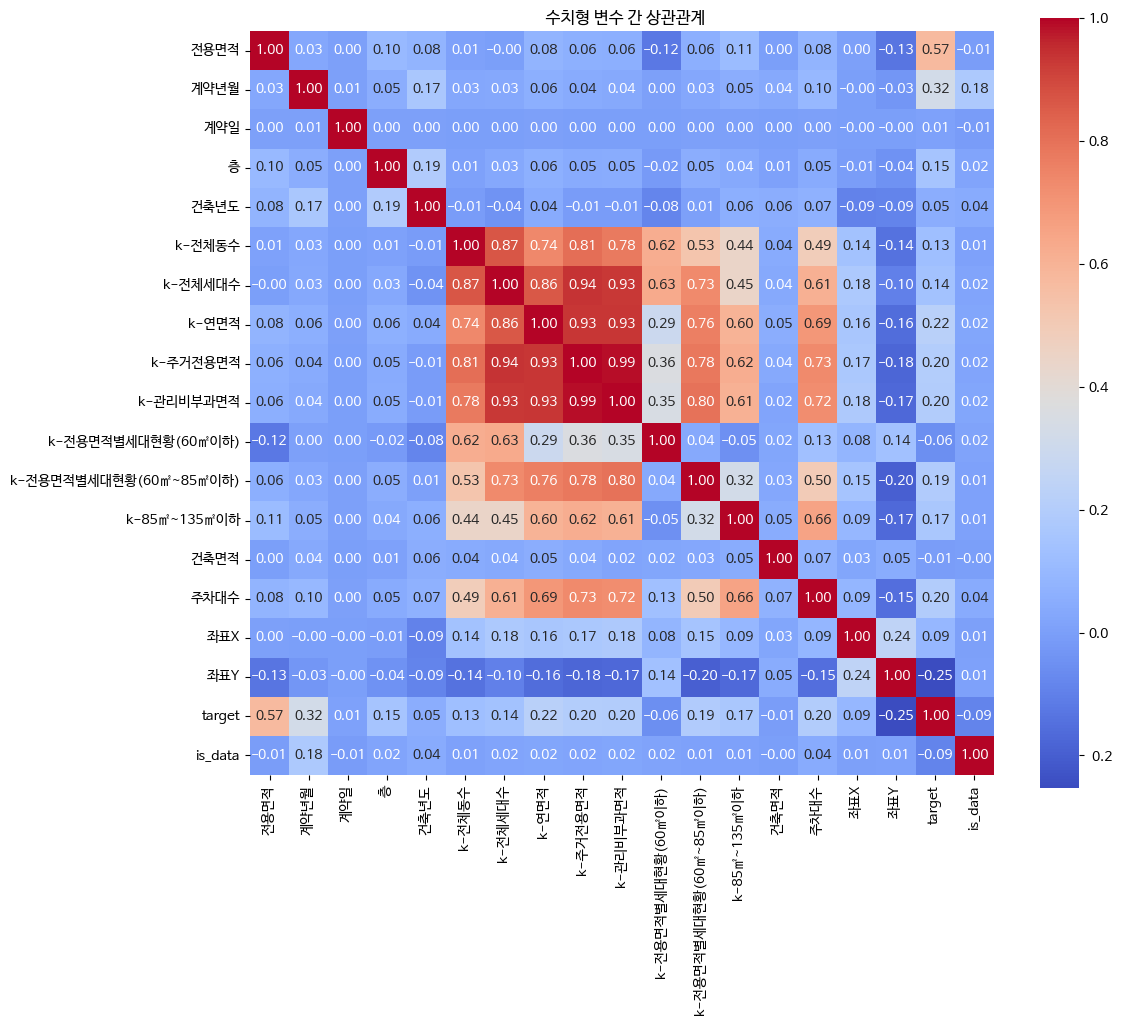

In [38]:
# 이상치 제거 전 상관관계 한번 봐보기..
# 1. 수치형 변수만 선택
numeric_cols = concat_select.select_dtypes(include=['float64', 'int64']).columns

# 2. 상관관계 계산
corr = concat_select[numeric_cols].corr()

# 3. 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 수치형 변수 간 상관관계")
plt.show()

# 결과값 보면 k- 이 열이 필요한가 싶은데...
# 집값이 세대수 많을수록 비싸기도 한데 -> 단지 형성 -> 생활 인프라 구축됨
# 유사한 변수가 보이는데 차원 축소 해..? 말아..?...

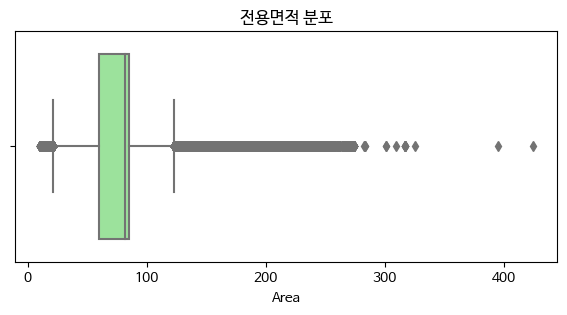

In [39]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [40]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_data == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_data == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [41]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [42]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 45)


In [43]:
concat_select['is_data'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_data, dtype: int64

In [44]:
# 유사한 변수 차원 축소

pca_cols = ['k-관리비부과면적', 'k-주거전용면적', 'k-연면적']

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 변수 추출 (결측치는 이미 없다고 가정_선형보간 했으니까)
scaled = StandardScaler().fit_transform(concat_select[pca_cols])

# 2. PCA 적용
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

# 3. 주성분 결과 저장
concat_select['면적_PC1'] = components[:, 0]
concat_select['면적_PC2'] = components[:, 1]


In [46]:
# 차원축소 설명력 확인
# 해석하는 법 : 첫 번째 주성분 설명력은 96.56%, 두 번째는 2.97%정도 둘의 합 99.5% 정도 정보 보

print("📊 주성분별 설명된 분산 비율:", pca.explained_variance_ratio_)
print("✅ 누적 설명력:", pca.explained_variance_ratio_.sum())

📊 주성분별 설명된 분산 비율: [0.96561985 0.02973388]
✅ 누적 설명력: 0.9953537292325341


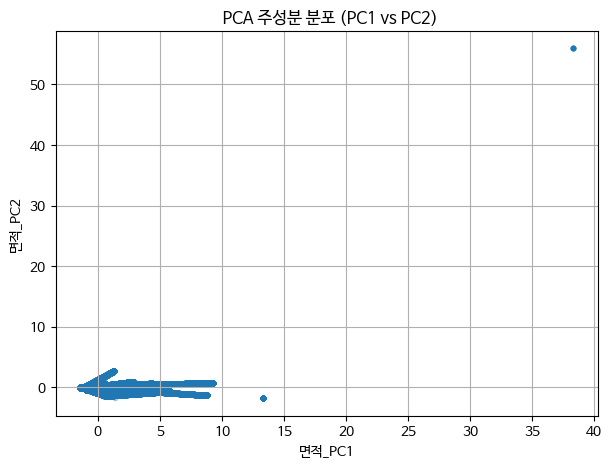

In [47]:
# PCA 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(concat_select['면적_PC1'], concat_select['면적_PC2'], alpha=0.3, s=10)
plt.title('📌 PCA 주성분 분포 (PC1 vs PC2)')
plt.xlabel('면적_PC1')
plt.ylabel('면적_PC2')
plt.grid(True)
plt.show()


In [52]:
# 면적_PC1, 면적_PC2 기준으로 극단값 확인
print(concat_select[['면적_PC1', '면적_PC2']].describe())

             면적_PC1        면적_PC2
count  1.038846e+06  1.038846e+06
mean   2.932877e-17 -1.805689e-17
std    1.702017e+00  2.986666e-01
min   -1.430431e+00 -1.773867e+00
25%   -9.449110e-01 -4.457893e-02
50%   -5.912706e-01  1.089380e-03
75%    2.093058e-01  4.286892e-02
max    3.832718e+01  5.595067e+01


In [57]:
# 이상치 제거
def remove_outliers_pca(concat_select, pc1_col='면적_PC1', pc2_col='면적_PC2'):
    q1_pc1, q3_pc1 = concat_select[pc1_col].quantile([0.25, 0.75])
    iqr_pc1 = q3_pc1 - q1_pc1
    lower_pc1 = q1_pc1 - 1.5 * iqr_pc1
    upper_pc1 = q3_pc1 + 1.5 * iqr_pc1

    q1_pc2, q3_pc2 = concat_select[pc2_col].quantile([0.25, 0.75])
    iqr_pc2 = q3_pc2 - q1_pc2
    lower_pc2 = q1_pc2 - 1.5 * iqr_pc2
    upper_pc2 = q3_pc2 + 1.5 * iqr_pc2

    filtered = concat_select[
        (concat_select[pc1_col] >= lower_pc1) & (concat_select[pc1_col] <= upper_pc1) &
        (concat_select[pc2_col] >= lower_pc2) & (concat_select[pc2_col] <= upper_pc2)
    ]
    return filtered


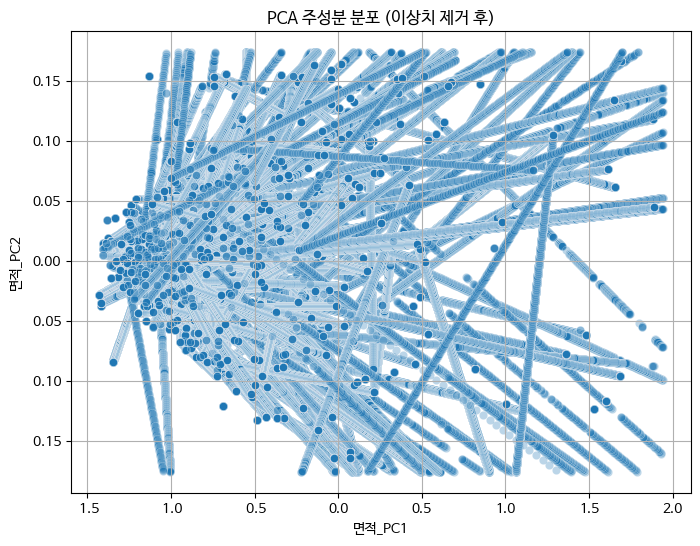

In [58]:
# 이상치 제거 후 결과를 filtered에 저장
filtered = remove_outliers_pca(concat_select, pc1_col='면적_PC1', pc2_col='면적_PC2')

plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered, x='면적_PC1', y='면적_PC2', alpha=0.3)
plt.title('PCA 주성분 분포 (이상치 제거 후)')
plt.xlabel('면적_PC1')
plt.ylabel('면적_PC2')
plt.grid(True)
plt.show()

In [59]:
# 왜 저러냐고
# filtered 값 분포 확인

filtered[['면적_PC1', '면적_PC2']].describe()

,면적_PC1,면적_PC2
count,870195.000000,870195.000000
mean,-0.517392,0.000713
std,0.697360,0.061460
min,-1.430431,-0.175750
25%,-1.002254,-0.034288
50%,-0.740787,0.001620
75%,-0.270252,0.032375
max,1.940444,0.174033


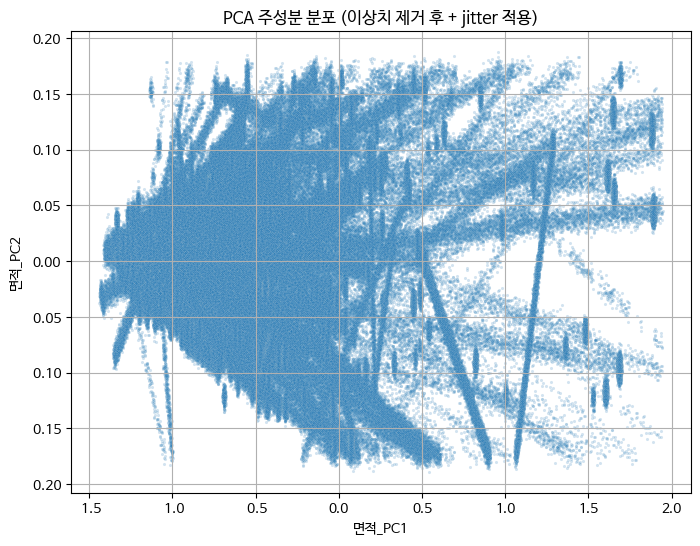

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# jitter 추가
jittered = filtered.copy()
jittered['면적_PC1'] += np.random.normal(0, 0.005, size=len(jittered))
jittered['면적_PC2'] += np.random.normal(0, 0.005, size=len(jittered))

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=jittered, x='면적_PC1', y='면적_PC2', alpha=0.2, s=5)
plt.title('PCA 주성분 분포 (이상치 제거 후 + jitter 적용)')
plt.xlabel('면적_PC1')
plt.ylabel('면적_PC2')
plt.grid(True)
plt.show()


In [61]:
# 노이즈를 넣어도 이상하니 스케일링 확인

from sklearn.preprocessing import StandardScaler

# 예: k-면적 계열
cols = ['k-관리비부과면적', 'k-주거전용면적', 'k-연면적']
scaled = StandardScaler().fit_transform(concat_select[cols])


In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

print(pca.explained_variance_ratio_)


[0.96561985 0.02973388]


In [48]:
## 특성 공학 ; 파생 변수 만들기

In [49]:
concat_select['시군구'].head()

0    서울특별시 강남구 개포동
1    서울특별시 강남구 개포동
2    서울특별시 강남구 개포동
3    서울특별시 강남구 개포동
4    서울특별시 강남구 개포동
Name: 시군구, dtype: object

In [50]:
concat_select['계약년월'].head()

0    201712
1    201712
2    201712
3    201801
4    201801
Name: 계약년월, dtype: int64